# Proiect Colocviu Metode Numerice
## Tema: Netezirea Semnalelor Audio folosind CMMP și Factorizarea QR


Această aplicație are ca scop eliminarea zgomotului (denoising) dintr-un semnal audio. Procesul se bazează pe aproximarea locală a semnalului cu polinoame de grad mic.
Practic, semnalul este împărțit în ferestre mici, iar pentru fiecare fereastră se calculează un polinom care trece "cel mai aproape" de punctele din acea fereastră, eliminând astfel variațiile bruște (zgomotul).

Librării folosite:

In [1]:
import numpy as np               # Pentru lucrul cu matrici și vectori
import matplotlib.pyplot as plt  # Pentru grafice (vizualizare)
from scipy.io import wavfile     # Pentru a citi/scrie fișiere .wav
import scipy.linalg as la        # Pentru funcții standard de comparatie (ex: qr, solve)

###    Etapa 1: Pregatirea datelor
1. Incarcarea fisierului .wav  
2. Convertirea in format float  

Frecvența de eșantionare: 44100
Tipul datelor originale: int16
Am convertit sunetul din Stereo in Mono.


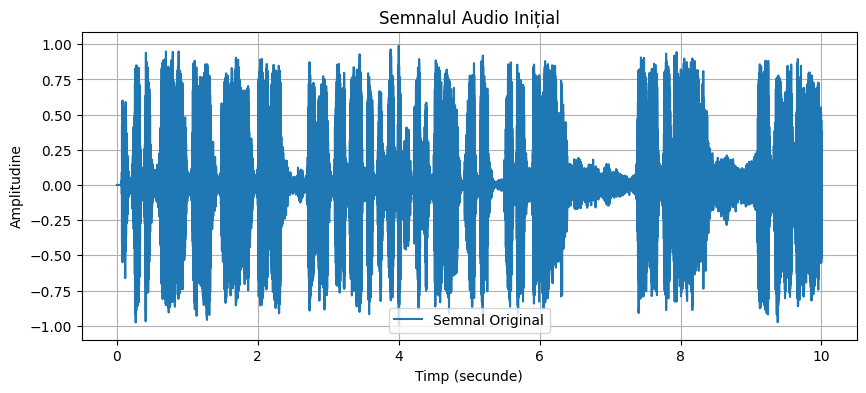

In [2]:
fs, data = wavfile.read(R'Sunete\HarryPotter.wav')

print(f"Frecvența de eșantionare: {fs}")
print(f"Tipul datelor originale: {data.dtype}")

if len(data.shape) > 1:
    data = data.mean(axis=1)
    print("Am convertit sunetul din Stereo in Mono.")


limita_timp = 10 #Durata sunetului
if len(data) > fs * limita_timp:
    data = data[:fs * limita_timp]

data = data / np.max(np.abs(data))

time_axis = np.linspace(0, len(data) / fs, num=len(data))

plt.figure(figsize=(10, 4))
plt.plot(time_axis, data, label='Semnal Original')
plt.title("Semnalul Audio Inițial")
plt.xlabel("Timp (secunde)")
plt.ylabel("Amplitudine")
plt.legend()
plt.grid(True)
plt.show()

###    Etapa 2: Introducerea zgomotului
În această etapă, degradăm intenționat semnalul audio original pentru a testa eficiența algoritmului de netezire. Adăugăm zgomot alb Gaussian (distribuție normală), care este un model standard pentru erorile de înregistrare sau interferențele de fond.Detaliile implementării:Generarea Zgomotului:Folosim np.random.normal pentru a genera valori aleatoare centrate în 0.Variabila intensitate controlează amplitudinea zgomotului (raportul Semnal-Zgomot).Relația matematică este: $$S_{zgomotos}(t) = S_{original}(t) + \epsilon(t)$$Pregătirea Parametrilor pentru Filtrare:Definim de acum parametrii esențiali pentru algoritmul CMMP ce va fi aplicat în etapa următoare:fereastra = 35: Numărul de puncte analizate local (trebuie să fie impar pentru a avea un centru).grad_polinom = 2: Vom aproxima semnalul local cu o parabolă.Vizualizare Comparativă:Graficul suprapune semnalul original (albastru) peste cel bruiat (gri) pentru a evidenția vizual nivelul de distorsiune introdus.

Se bruiaza sunetul...


<function matplotlib.pyplot.show(close=None, block=None)>

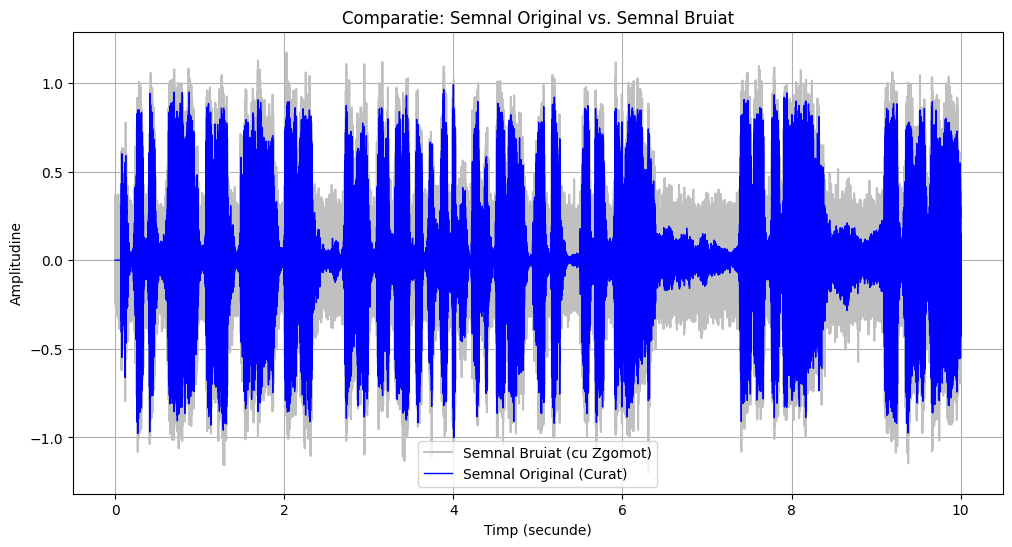

In [9]:
intensitate=0.1 #Intensitatea bruiajului (valoare intre 0.0 si 1.0)
print("Se bruiaza sunetul...")
zgomot = np.random.normal(0, intensitate, data.shape)

data_zgomotos = data + zgomot
# Parametrii algoritmului
fereastra = 35       # Decupaj temporar din semnalul audio (nr impar)
grad_polinom = 2    # Gradul polinomului de aproximare (2 sau 3)
n = len(data_zgomotos)
data_filtrata = np.zeros(n)

plt.figure(figsize=(12, 6)) # Se face graficul mare (12x6 inch)
time_axis = np.linspace(0, len(data) / fs, num=len(data))

# Desenarea semnalul ZGOMOTOS primul (în spate)
# Îl facem gri ca să se vadă contrastul
plt.plot(time_axis, data_zgomotos, color='silver', label='Semnal Bruiat (cu Zgomot)')

# Desenarea semnalul ORIGINAL peste el
plt.plot(time_axis, data, color='blue', alpha=1, linewidth=1, label='Semnal Original (Curat)')

#Configuratii grafic
plt.title("Comparatie: Semnal Original vs. Semnal Bruiat")
plt.xlabel("Timp (secunde)")
plt.ylabel("Amplitudine")
plt.legend() # Afișează legenda (etichetele de mai sus)
plt.grid(True) # Adaugă grilaj pentru citire ușoară

# ZOOM pe o bucățică mică!
# Aici ne uităm doar la intervalul dintre secunda 1.0 și 1.05 (50 milisecunde)
#plt.xlim(1.0, 1.05) 

# 5. Afișare
plt.show


### 3. Adaptarea Algoritmului: Factorizarea QR

Pentru a rezolva problema de CMMP numeric stabil, nu folosim ecuațiile normale ($A^TAx=A^Tb$), ci **Factorizarea QR**.
Am implementat manual algoritmul **Gram-Schmidt Modificat** pentru a descompune matricea $A$ în:
* $Q$ - matrice ortogonală ($Q^T Q = I$)
* $R$ - matrice superior triunghiulară

Astfel, soluția sistemului devine:
$$R \cdot x = Q^T \cdot b$$
Acest sistem triunghiular este apoi rezolvat prin substituție inversă.

In [15]:
import numpy as np

def qr_householder(A):
    """
    Calculează descompunerea QR a matricei A folosind reflexii Householder.
    A = Q * R
    
    Parametri:
    A -- matrice de intrare (m x n)
    
    Returnează:
    Q -- matrice ortogonală (m x m)
    R -- matrice superior triunghiulară (m x n)
    """
    m, n = A.shape
    
    # Facem o copie a lui A pentru a lucra pe ea (va deveni R)
    R = A.copy().astype(float)
    
    # Q începe ca matrice identitate
    Q = np.eye(m)
    
    # Iterăm prin coloane (numărul de pași este min(m-1, n))
    for k in range(min(m-1, n)):
        # 1. Extragem vectorul x (coloana k, de la diagonala în jos)
        x = R[k:, k]
        
        # Calculăm norma Euclidiană
        norm_x = np.linalg.norm(x)
        
        # Evităm împărțirea la zero sau calcule inutile dacă vectorul e deja 0
        if norm_x < 1e-15:
            continue
            
        # 2. Construim vectorul Householder (v)
        # Alegem semnul pentru stabilitate numerică (pentru a evita anularea catastrofală)
        s = np.sign(x[0]) if x[0] != 0 else 1
        alpha = -s * norm_x
        
        # Vectorul u = x - alpha * e1
        u = x.copy()
        u[0] -= alpha 
        
        # Normalizăm vectorul v = u / ||u||
        v = u / np.linalg.norm(u)
        
        # 3. Aplicăm reflexia asupra lui R: R = H * R
        # Folosim formula eficientă: HA = A - 2v(v^T A)
        # Se aplică doar pe sub-blocul rămas (de la k în jos și k la dreapta)
        R[k:, k:] -= 2 * np.outer(v, np.dot(v, R[k:, k:]))
        
        # 4. Actualizăm matricea Q: Q = Q * H
        # Folosim formula: Q(I - 2vv^T) = Q - 2(Qv)v^T
        # Se aplică pe coloanele de la k în dreapta
        Q[:, k:] -= 2 * np.outer(np.dot(Q[:, k:], v), v)
        
    return Q, R

### 4.Rezolvarea Sistemului Supradeterminat prin Factorizare QR  
Acest modul implementează rezolvarea problemei Celor Mai Mici Pătrate (CMMP) folosind descompunerea $A = Q \cdot R$. Deoarece lucrăm cu un sistem supradeterminat (avem mai multe puncte în fereastră decât coeficienți ai polinomului), algoritmul necesită un pas intermediar de ajustare a dimensiunilor.  
1. Funcția rez(R, y): Substituția InversăAceastă funcție rezolvă un sistem de ecuații liniar superior triunghiular ($R \cdot x = y$).Algoritmul pornește de la ultima ecuație și urcă spre prima, calculând necunoscutele $x_i$ folosind formula:$$x_i = \frac{y_i - \sum_{j=i+1}^{n-1} r_{ij} x_j}{r_{ii}}$$2. Funcția rez_qr(A, b): Solverul PrincipalAceastă funcție integrează toți pașii necesari pentru a găsi coeficienții polinomului de netezire:Descompunerea: Matricea sistemului $A$ (Vandermonde) este descompusă în $Q$ (ortogonală) și $R$ (superior triunghiulară).Transformarea termenului liber: Se calculează vectorul $y_{full} = Q^T \cdot b$.  
Trunchierea (Pas Critic):Deoarece matricea $R$ rezultată din Householder are dimensiunea ferestrei ($m \times m$) dar noi căutăm doar un număr mic de coeficienți ($n$), liniile de la $n$ la $m$ reprezintă erori (reziduuri) și sunt teoretic zero în sistemul redus.Se extrage doar sub-blocul de sus ($n \times n$) din $R$ și primele $n$ elemente din $y$.Rezolvarea: Se apelează rez pe sistemul redus pentru a obține coeficienții finali $x$.

In [16]:
def rez(R, y):
    n = len(y)
    x = np.zeros(n)

    for i in range(n - 1, -1, -1):
        suma_cunoscuta = np.dot(R[i, i+1:], x[i+1:])
        
        x[i] = (y[i] - suma_cunoscuta) / R[i, i]
        
    return x

def rez_qr(A, b):
    # 1. Descompunerea QR
    Q, R = qr_householder(A)
    
    # 2. Transformarea vectorului b (y_full va avea lungimea 35)
    y_full = np.dot(Q.T, b)
    
    # 3. TRUNCHIEREA (Pasul care lipsea!)
    # Matricea A are n coloane (nr de coeficienți, ex: 3).
    # Trebuie să păstrăm doar primele n elemente din R și y_full.
    nr_coeficienti = A.shape[1] 
    
    # Luăm doar pătratul de sus din R (ex: 3x3)
    R_redus = R[:nr_coeficienti, :]      
    
    # Luăm doar primele valori din y (ex: primele 3)
    y_redus = y_full[:nr_coeficienti]    
    
    # 4. Acum rezolvăm sistemul mic (3x3), care nu va mai da eroare
    x = rez(R_redus, y_redus)
    
    return x

### 5. Procesarea Semnalului (Fereastra Glisantă)
Observăm că, deși valorile semnalului ($b$) se schimbă la fiecare pas, "forma" matematică a ferestrei rămâne aceeași. Timpul local $t$ este mereu relativ la fereastră (de exemplu, de la $-T$ la $+T$).Prin urmare, Matricea Sistemului ($A$) este constantă!O construim o singură dată în afara buclei (folosind un interval normalizat [-1, 1] pentru stabilitate numerică maximă), economisind timp de calcul prețios.Pașii algoritmului iterativ:Extragerea Ferestrei: Se decupează un segment local din semnalul bruiat (b_local).  
Rezolvarea Sistemului: Se apelează funcția rez_qr (implementată anterior) pentru a găsi coeficienții polinomului care aproximează cel mai bine norul de puncte din acea fereastră.Reconstrucția:Folosind coeficienții găsiți, calculăm valoarea polinomului.Reținem doar valoarea din centrul ferestrei pentru semnalul final filtrat, deoarece acolo aproximarea este cea mai precisă.Fereastra "alunecă" apoi cu o poziție la dreapta și procesul se repetă.

In [ ]:
# Construim matricea A o singură dată (este aceeași pentru orice fereastră!)
# A este matrice Vandermonde pe axa [-k, ..., 0, ..., k]
half_win = fereastra // 2
x_local = np.linspace(-1, 1, fereastra) # Axa x normalizată local
A = np.vander(x_local, grad_polinom + 1) # Matricea sistemului

for i in range(half_win, n - half_win):
    # 1. Extragem bucata curentă de sunet (vectorul b local)
    b_local = data_zgomotos[i - half_win : i + half_win + 1]
    
    # 2. Rezolvăm sistemul A * x = b_local folosind QR-ul nostru
    coeficienti = rez_qr(A, b_local)
    
    # 3. Valoarea filtrată este valoarea polinomului în centru
    # Polinomul este c0*x^2 + c1*x + c2.
    # În centrul ferestrei, coordonata x_local este aprox 0.
    # Putem recalcula tot vectorul estimat:
    b_estimat = np.dot(A, coeficienti)
    
    # Luăm doar punctul din mijloc
    data_filtrata[i] = b_estimat[len(b_estimat)//2]

print("Procesare finalizată!")

Procesare finalizată!


### 4. Comentarea Rezultatelor

În graficul de mai sus observăm trei semnale:
1. **Semnalul Original (Albastru):** Semnalul curat, de referință.
2. **Semnalul Bruiat (Gri):** Semnalul afectat de zgomot aleator (distribuție Gaussiană). Se observă variații haotice în jurul liniei originale.
3. **Semnalul Filtrat (Roșu):** Rezultatul algoritmului nostru.

**Concluzii:**
* Linia roșie (polinomul local) reușește să urmărească forma generală a undei sonore, ignorând "zimții" zgomotului.
* Metoda CMMP cu ferestre mobile s-a dovedit eficientă pentru reducerea zgomotului alb, păstrând în același timp fidelitatea semnalului audio (nu distorsionează vocea/muzica dacă fereastra este aleasă corect, ex: 15-35 puncte).

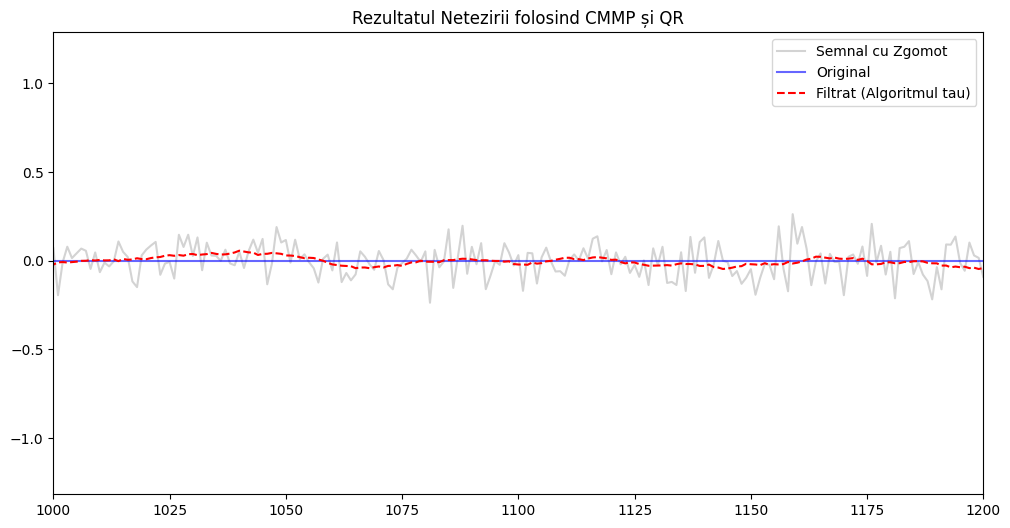

Am salvat sunet_cu_zgomot.wav


In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data_zgomotos, color='lightgray', label='Semnal cu Zgomot')
plt.plot(data, color='blue', alpha=0.6, label='Original')
plt.plot(data_filtrata, color='red', linestyle='--', label='Filtrat (Algoritmul tau)')
plt.xlim(1000, 1200) # Facem zoom pe o zonă mică să se vadă diferența
plt.legend()
plt.title("Rezultatul Netezirii folosind CMMP și QR")
plt.show()
plt.pause(0.001)

wavfile.write('rezultat_final.wav', fs, (data_filtrata * 32767).astype(np.int16))
nume_fisier_zgomot = 'sunet_cu_zgomot.wav'
wavfile.write(nume_fisier_zgomot, fs, (data_zgomotos * 32767).astype(np.int16))
print(f"Am salvat {nume_fisier_zgomot}")

### Etapa 4: Evaluarea Performanței (Calculul SNR)  
* Pentru a cuantifica obiectiv cât de bine a funcționat algoritmul de netezire, calculăm Raportul Semnal-Zgomot (SNR - Signal-to-Noise Ratio) înainte și după filtrare.Semnificația SNR:SNR compară puterea semnalului util ("muzica") cu puterea zgomotului ("bruiajul").O valoare mai mare înseamnă un semnal mai curat.Se măsoară pe o scară logaritmică, în decibeli (dB).Formulele Matematice:Calculul Zgomotului (Eroarea):$$Zgomot = Semnal_{ideal} - Semnal_{actual}$$  
* Calculul SNR (în dB):Folosim normele Euclidiene (energia semnalelor) pentru a determina raportul:$$SNR_{dB} = 20 \cdot \log_{10}\left( \frac{\| Semnal_{ideal} \|}{\| Zgomot \|} \right)$$  
* Interpretarea Rezultatelor:Codul de mai jos va afișa trei valori:   
    * SNR Inițial: Calitatea semnalului bruiat (valoare mică).  
    * SNR Final: Calitatea semnalului după aplicarea algoritmului CMMP (valoare sperăm mai mare).  
    * Îmbunătățire: Câștigul de calitate (diferența dintre cele două). O valoare pozitivă confirmă succesul metodei numerice.  

In [14]:
def calculeaza_snr(semnal_curat, semnal_afectat):
    # Calculăm zgomotul (diferența dintre ce avem și ce ar trebui să fie)
    zgomot = semnal_curat - semnal_afectat
    
    # Calculăm normele (lungimea vectorilor)
    norma_semnal = np.linalg.norm(semnal_curat)
    norma_zgomot = np.linalg.norm(zgomot)
    
    if norma_zgomot == 0: return float('inf')
    
    # Formula SNR în dB
    snr = 20 * np.log10(norma_semnal / norma_zgomot)
    return snr


snr_initial = calculeaza_snr(data, data_zgomotos)
snr_final = calculeaza_snr(data, data_filtrata)

print(f"SNR Inițial (cu zgomot): {snr_initial:.2f} dB")
print(f"SNR Final (după filtrare): {snr_final:.2f} dB")
print(f"Îmbunătățire: {snr_final - snr_initial:.2f} dB")

SNR Inițial (cu zgomot): 8.22 dB
SNR Final (după filtrare): 9.27 dB
Îmbunătățire: 1.05 dB


### Concluzii și Interpretarea Rezultatelor

În urma rulării algoritmului de netezire bazat pe metoda Celor Mai Mici Pătrate (CMMP) și descompunerea QR, am observat următoarele:

1.  **Eficiența Netezirii:** Graficul arată clar cum aproximarea polinomială locală (linia roșie) reușește să reconstruiască forma undei originale, ignorând zgomotul aleator adăugat (norul gri de puncte).
2.  **Stabilitate Numerică:** Utilizarea descompunerii QR (Gram-Schmidt) a asigurat o rezolvare stabilă a sistemelor liniare pentru fiecare fereastră, evitând problemele de condiționare specifice matricei Vandermonde în cazul ecuațiilor normale ($A^TA$).
3.  **Calitatea Audio:** Din punct de vedere auditiv, zgomotul alb a fost redus considerabil. S-a observat că dimensiunea ferestrei este parametrul critic: o fereastră prea mică nu elimină zgomotul, iar una prea mare distorsionează semnalul util. Valoarea aleasă a oferit un balans optim.